### Classificação de textos para análise de sentimentos

### Aluno: Guilherme Cristiano Goll

In [1]:
from torchtext import datasets
import torchtext
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchtext.legacy import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import seaborn as sns

In [2]:
print('Versão do Pytorch', torch.__version__)
print('Versão do torchtext', torchtext.__version__)

Versão do Pytorch 1.8.1+cu111
Versão do torchtext 0.9.1


In [3]:
SEED = 43

torch.manual_seed(SEED)

In [4]:
train_iter, test_iter = datasets.IMDB()

In [5]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

Ao invés de trabalhar com os cursores iterativos `train_iter` e `test_iter`, transformei ambos em `Numpy.array` e em seguida em um `Pandas.DataFrame`, que torna a leitura e manipulação dos dados mais simples.

Obs: este procedimento é relativamente _lento_.

In [6]:
df_train = np.array(train_iter)
df_train = pd.DataFrame(df_train, columns=['sentiment', 'review'])

df_test = np.array(test_iter)
df_test = pd.DataFrame(df_test, columns=['sentiment', 'review'])

In [7]:
def distribution(df, column, title_sufix: str=None):
    '''
    Plota a distribuição da coluna em um gráfico de barras horizontal.
    '''
    fig, ax = plt.subplots(figsize=(16,9))
    grouped = df[column].value_counts().sort_values(ascending=True)

    df_grouped = grouped.to_frame()
    df_grouped.reset_index(level=0, inplace=True)
    df_grouped.columns = ['item', 'count']
    labels = df_grouped['item'].astype(str)
    values = df_grouped['count']

    ax.clear()
    ax.barh(labels, values, alpha=0.75)
    for i, (value, name) in enumerate(zip(values, labels)):
        ax.text(value, i, value, size=12, ha='left', va='center')

    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.margins(0.003, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    
    title = 'Distribuição de classes'
    if title_sufix is not None:
        title = f'{title} no conjunto de {title_sufix}'
        
    ax.set_title(title)

Após a leitura e transformação inicial do conjunto de dados, verificamos através do gráfico a seguir a distribuição dos registros no conjunto de treino.

Felizmente, os dados estão balanceados, o que auxilia na redução do viés ao treinar e testar o modelo, mais a frente.

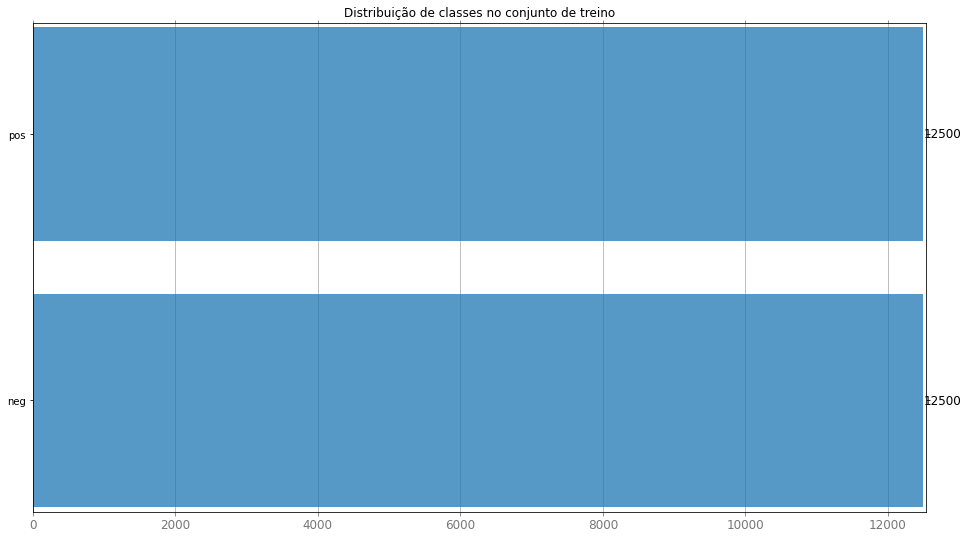

In [8]:
distribution(df_train, 'sentiment', 'treino')

# Pré-tratamento dos dados

Antes de iniciar a aplicação de algoritmos de ML para classificação dos dados, por se tratar de um conjunto de dados textual serão aplicados alguns tratamentos no texto.

Em especial, serão removidas as _stopwords_ e a pontuação em geral, e é aplicada a técnica _stem_.

In [9]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guilh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\guilh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [10]:
def normalize_df(df, index: int=1, remove_punc: bool=True):
    '''Realiza a limpeza e normalização do dataframe: remoção de stopwords e 
    pontuação, e aplicação de stem
    df -> dataframe que será normalizado
    index -> índice da coluna que será normalizada (aquela que contém o 
    texto). Default é 1
    remove_punc -> Deve remover a pontuação? Padrão é True
    '''
    ps = PorterStemmer()
    t_df = df.copy()
    stop_words=set(stopwords.words("english"))
    tokenizer = RegexpTokenizer(r'\w+')
    
    def normalize(text: str):        
        final_sent = []
        if remove_punc:
            tokenized_words = tokenizer.tokenize(text)
            for word in tokenized_words:
                if word not in stop_words:
                    stemmed_word = ps.stem(word)
                    final_sent.append(' ' + stemmed_word)
        else:
            tokenized_sent = sent_tokenize(text.strip())
            for sent in tokenized_sent:
                tokenized_words = word_tokenize(sent)
                for word in tokenized_words:
                    if word not in stop_words:
                        stemmed_word = ps.stem(word)
                        final_sent.append(' ' + stemmed_word)
            
        
        return ''.join(final_sent)
    
    for idx in range(len(t_df)):
        t_df.iat[idx, index] = normalize(t_df.iloc[idx, index])
        if (idx + 1) % 5000 == 0:
            print(f'{idx + 1} documentos normalizados')
    
    return t_df

In [11]:
df_train_normalized = normalize_df(df_train, remove_punc=True)

5000 documentos normalizados
10000 documentos normalizados
15000 documentos normalizados
20000 documentos normalizados
25000 documentos normalizados


## Word Embedding

O Word Embedding é um processo de transformação de palavras/ texto em números.

Após realizar a limpeza dos dados no conjunto de treino completo, vamos transformá-lo em números utilizando o `TfIdfVectorizer`. O __TF-IDF__ mede estatisticamente a relevância de uma palavra (ou N-grams) junto a um conjunto de documentos, multiplicando a frequência da palavra no documento (__TF__) pela frequência inversa das palavras em um conjunto de documentos (__IDF__).

In [12]:
#Separação das features (X) e variável predita (y)
X, y = df_train_normalized['review'], df_train_normalized['sentiment']

__IMPORTANTE__: o enunciado deste problema nos fornece dois conjuntos de dados: treino e teste. No entanto, o conjunto de treino será sub-dividido durante o treinamento do modelo para fins de treino e teste (aferição inicial dos resultados). Em seguida, o conjunto original de teste será utilizado para __validação__, que também deve exibir a acurácia do modelo sob este conjunto de dados.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=SEED, stratify=y)

Após dividir o conjunto inicial de treino, para treino e teste, será montado o vocabulário. Ele consiste numa lista de palavras, bi-gramas e tri-gramas (conjuntos de duas e três palavras respectivamente), que será transformado em números.

Porém, serão utilizadas apenas as palavras/n-gramas que tenham uma frequência relevante para os dados avaliados.

Este conjunto será a base para comparação textual e treinamento do modelo, logo, ele será a principal _feature_ do modelo.

In [14]:
from collections import Counter

vocabulary = set([])
for _class in np.unique(df_train_normalized['sentiment']):
    words = []
    bigrams = []
    trigrams = []
    df_words = dict()
    df_bigrams = dict()
    df_trigrams = dict()
    doc_frequency = 0
    
    for line in df_train_normalized[df_train_normalized['sentiment'] == _class]['review'].values:
        doc_words = []
        doc_bigrams = []
        doc_trigrams = []
        doc_frequency += 1
        
        line_text = line.split(' ')
        for idx, word in enumerate(line_text):
            doc_words.append(word)
            if idx > 0:
                doc_bigrams.append(f'{line_text[idx - 1]} {line_text[idx]}')
            if idx > 1:
                doc_trigrams.append(f'{line_text[idx - 2]} {line_text[idx - 1]} {line_text[idx]}')
        
        words.extend(doc_words)
        for d_w in set(doc_words):
            if d_w in df_words:
                df_words[d_w] += 1
            else:
                df_words[d_w] = 1
                
        bigrams.extend(doc_bigrams)
        for d_b in set(doc_bigrams):
            if d_b in df_bigrams:
                df_bigrams[d_b] += 1
            else:
                df_bigrams[d_b] = 1
        
        trigrams.extend(doc_trigrams)
        for d_t in set(doc_trigrams):
            if d_t in df_trigrams:
                df_trigrams[d_t] += 1
            else:
                df_trigrams[d_t] = 1
    
    size1 = max(2, int(doc_frequency * 0.01))
    size2 = max(2, int(doc_frequency * 0.01))
    size3 = max(2, int(doc_frequency * 0.01))
    
    c1 = Counter(words)
    c2 = Counter(bigrams)
    c3 = Counter(trigrams)
    words = [word[0] for word in c1.most_common() if df_words[word[0]] >= size1]
    bigrams = [bigram[0] for bigram in c2.most_common() if df_bigrams[bigram[0]] >= size2]
    trigrams = [trigram[0] for trigram in c3.most_common() if df_trigrams[trigram[0]] >= size3]
    vocabulary |= set(words)
    vocabulary |= set(bigrams)
    vocabulary |= set(trigrams)

print('Tamanho final do vocabulário', len(vocabulary))

Tamanho final do vocabulário 2558


A seguir é realizado o 'treinamento', utilizando o conjunto __completo__, e as transformação dos sub-conjuntos utilizando as respectivas parcelas dos dados (treino e teste).

In [15]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), use_idf=True, vocabulary=vocabulary)
tfidf_vectorizer.fit(X.to_numpy())

train_review_tf = tfidf_vectorizer.transform(X_train.to_numpy()).toarray()
test_review_tf = tfidf_vectorizer.transform(X_test.to_numpy()).toarray()

A saída abaixo representa as dimensões das features (17500 linhas por 2558 colunas).

In [16]:
train_review_tf.shape

(17500, 2558)

Uma vez realizada a transformação da parte textual semântica (review) do dataset, também é necessário aplicar um tratamento especial à variável predita: _sentiment_. Isto porque ela é do tipo texto. Para tratá-la, a mesma será transformada em uma variável categória numérica (0 e 1), utilizando o `LabelEncoder`, embora também seja possível utilizar o `LabelBinarizer`.

In [17]:
le = LabelEncoder()
le_y_train = le.fit_transform(y_train)
le_y_test = le.transform(y_test)

Agora, contando com as _features_ e saídas respectivamente codificadas, as mesmas serão transformadas em um tensor do PyTorch.

In [18]:
X_train, X_test, y_train, y_test = map(
    torch.tensor, (train_review_tf, test_review_tf, le_y_train, le_y_test)
)

In [19]:
input_size = X_train.shape[1]
output_size = len(y.unique())
bs = 500 #batch size

Por fim, os sub-conjuntos de treino e teste serão inseridos em objetos do tipo `DataLoader`, uma abstração do PyTorch que facilita as iterações (épocas) e a utilização do _batch size_.

In [20]:
drop_last = False

if X_train.size(0) % bs > 0:
    print('ATENÇÃO: como a quantidade de linhas do conjunto de treino não é divisível pelo batch size informado,',
          'o modelo irá ignorar o último batch de dados')
    drop_last = True

train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=drop_last)
test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs, drop_last=drop_last)

# Treinamento do modelo

O modelo abaixo é do tipo *LSTM*.

In [21]:
def acc(pred, label):
    '''Verifica a acurária das predições realizadas'''
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [22]:
class LSTM(nn.Module):
    def __init__(self, no_layers, hidden_dim, input_size, output_size, drop_prob=0.5):
        super(LSTM, self).__init__() 
        self.output_dim = output_size
        self.hidden_dim = hidden_dim 
        self.no_layers = no_layers
        
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=self.hidden_dim,
                            num_layers=no_layers, 
                            batch_first=True).double()        
        
        self.dropout = nn.Dropout(0.3)
        
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.unsqueeze(1)        
        lstm_out, hidden = self.lstm(x.double(), hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        sig_out = self.sig(out)
        # reshape para o "batch_first=True"
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # pega o último batch
        
        return sig_out, hidden                
        
    def init_hidden(self, batch_size, device):
        '''Inicializa o hidden'''
        # Cria dois tensors com tamanho n_layers x batch_size x hidden_dim,
        # inicializados com zero, para o hidden e cell status do LSTM
        h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (h0.double(), c0.double())
        return hidden

As funções `loss_batch` e `valid_batch` são responsáveis por realizar as predições durante as etapas de treino e validação, respectivamente. A primeira efetua também a atualização dos gradientes/ pesos.

In [23]:
def loss_batch(model, device, xb, yb, hidden, opt=None):
    xb = xb.to(device)
    yb = yb.to(device)
    h = tuple([each.data for each in hidden])
    output, h = model(xb, h)
    loss = criterion(output, yb.double())

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def valid_batch(model, device, xb, yb, hidden):
    xb = xb.to(device)
    yb = yb.to(device)
    h = tuple([each.data for each in hidden])
    output, h = model(xb, h)
    loss = criterion(output, yb.double())
    correct = acc(output, yb)
    
    return loss.item(), correct, len(xb)

Através da função `fit` é que será realizado o treinamento do modelo, através de um loop a ser executado por `epochs` vezes.

In [24]:
def fit(model, opt, epochs, train_dl, test_dl, device):
    scheduler = None
    if opt is not None:
        scheduler = optim.lr_scheduler.StepLR(opt, step_size=2, gamma=0.5)
        
    for epoch in range(epochs):
        print(f'Iniciando época {epoch + 1}/{epochs}')
        model.train()
        hidden = model.init_hidden(train_dl.batch_size, device)
        losses, nums = zip(
            *[loss_batch(model, device, xb, yb, hidden, opt) for xb, yb in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            
        model.eval()
        with torch.no_grad():
            hidden = model.init_hidden(test_dl.batch_size, device)
            losses, corrects, nums = zip(
                *[valid_batch(model, device, xb, yb, hidden) for xb, yb in test_dl])
            test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            test_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f'- Train loss: {train_loss:.6f}\t',
                  f'Test loss: {test_loss:.6f}\t',
                  f'Test accuracy: {test_accuracy:.3f}%')
        
        if opt is None:
            print('Não há otimizador para este modelo. Loop de épocas será interrompido.')
            return model
        
        scheduler.step()    
    
    return model

In [25]:
lr = 0.001
epochs = 2
dropout = 0.5

model = LSTM(2, 256, input_size, output_size, dropout)
model = model.to(device)
#necessário para 'uniformizar' o tratamento dos números de ponto flutuante 
#ao utilizar placa de video (device = cuda)
model.double()
criterion = nn.BCELoss()
opt = optim.Adam(model.parameters(), lr=lr)

model_novo = fit(model, opt, epochs, train_dl, test_dl, device)

Iniciando época 1/2
- Train loss: 0.655113	 Test loss: 0.528081	 Test accuracy: 83.280%
Iniciando época 2/2
- Train loss: 0.357720	 Test loss: 0.293522	 Test accuracy: 88.080%


Após retreinar o modelo algumas vezes e com parâmetros diferentes, observei que o melhor resultado (menor test loss e melhor test accuracy) ocorriam entre o primeiro e o segundo loop. Dali em diante o train loss continuava reduzindo, porém o test loss subia, indicando _overfitting_ no conjunto de treino.

# Aplicação do modelo no conjunto de validação

Uma vez treinado o modelo, o mesmo será submetido ao conjunto de validação. Para isto, as mesmas etapas de pré-processamento junto ao texto serão aplicadas, tornando o _input_ apropriado ao modelo.

In [26]:
#pré-processamento do texto
df_test_normalized = normalize_df(df_test, remove_punc=True)

5000 documentos normalizados
10000 documentos normalizados
15000 documentos normalizados
20000 documentos normalizados
25000 documentos normalizados


In [27]:
#transformação do texto e variável predita
Xn, yn = df_test_normalized['review'], df_test_normalized['sentiment']
valid_review_tf = tfidf_vectorizer.transform(Xn.to_numpy()).toarray()
valid_yn_le = le.transform(yn)

In [28]:
#criação do DataLoader
Xn, yn = map(
    torch.tensor, (valid_review_tf, valid_yn_le)
)

valid_ds = TensorDataset(Xn, yn)
valid_dl = DataLoader(valid_ds, batch_size=500)

In [29]:
def validate_model(model, data_loader):
    '''Function to run the model with de validation dataset.'''
    model.cuda()
    model.eval()
    
    with torch.no_grad():
        hidden = model.init_hidden(data_loader.batch_size, 'cuda')
        losses, corrects, nums = zip(
                *[valid_batch(model, device, xb, yb, hidden) for xb, yb in test_dl])
        valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        valid_acc = np.sum(corrects) / np.sum(nums) * 100
        return valid_loss, valid_acc

In [30]:
valid_loss, valid_acc = validate_model(model_novo, valid_dl)
print('Resultado da execução do modelo no conjunto de validação:\n',
      f'\tLoss: {valid_loss}\n',
      f'\tAcurácia: {valid_acc:.2f}%')

Resultado da execução do modelo no conjunto de validação:
 	Loss: 0.29352208110365147
 	Acurácia: 88.08%


Com isto, observamos que o modelo retornou um resultado sustentável em relação ao período de treino. Ou seja, o modelo foi capaz de generalizar o conjunto de dados.

# Exportação do modelo

A exportação do modelo contará com as seguintes etapas:
- Salvar o modelo treinado
- Salvar o vetorizador (transformador de 'texto' em palavras)
- Salvar o encoder (tradução das labels da variável predita `sentiment` em categorias)

In [33]:
model_filepath = 'modelo.pth'
torch.save(model_novo, model_filepath)
tfidf_filepath = 'tfidf.pickle'
torch.save(tfidf_vectorizer, tfidf_filepath)
encoder_filepath = 'encoder.pickle'
torch.save(le, encoder_filepath)

# Importação do modelo e utilização em um ambiente simulado de produção

Após exportar o modelo, utilizaremos o mesmo num ambiente de produção simulado.
Para isto, foi criada a classe ``ModeloProducao``, que possui uma função ``predict`` que recebe o texto do _review_ a ser classificado e retorna uma descrição amigável da classificação ([positivo|negativo]) e a probabilidade da mesma.

**IMPORTANTE**: PARA QUE A IMPORTAÇÃO DO MODELO FUNCIONE CORRETAMENTE, ALÉM DO PRÓPRIO MODELO SALVO (EM FORMATO.pth) É NECESSÁRIA A EXECUÇÃO DA CÉLULA QUE DEFINE A CLASSE ``LSTM``, QUE É A BASE DO MODELO. OU SEJA, CASO DESEJA-SE UTILIZAR ESTE MODELO NUM AMBIENTE 'NOVO', DEVE-SE EXPORTAR E EXECUTAR A CÉLULA QUE CONTÉM A DEFINIÇÃO D CLASSE ``LSTM``.

In [34]:
class ModeloProducao():
    
    def __init__(self, model_path, tfidf_path, encoder_filepath):
        self.model = torch.load(model_path)
        self.model.cpu()
        self.hidden = self.model.init_hidden(1, 'cpu')
        self.hidden = tuple([each.data.to('cpu') for each in self.hidden])
        
        self.tfidf_vectorizer = torch.load(tfidf_path)
        
        self.label_encoder = torch.load(encoder_filepath)
    
    def predict(self, input_text: str):
        self.model.eval()
        tf_input = self.tfidf_vectorizer.transform(np.array([input_text])).toarray()
        ts_input = torch.tensor(tf_input).to('cpu')
        with torch.no_grad():
            output, h = self.model(ts_input, self.hidden)
            return self.decode_label(output)
        
    def decode_label(self, input):
        out = self.label_encoder.inverse_transform(
           [np.array(torch.round(input.squeeze())).astype(int)] 
        )[0]
        
        pretty_desc = 'positivo'
        proba = input[0] * 100
        if out == 'neg':
            proba = (1 - input[0]) * 100
            pretty_desc = 'negativo'
            
        return pretty_desc, proba

modelo_producao = ModeloProducao(model_filepath, tfidf_filepath, encoder_filepath)

In [35]:
good_review = "It's the best movie I've ever seen!"
review_classification, proba = modelo_producao.predict(good_review)
print(f'Há {proba:.2f}% de probabilidade do review acima ser {review_classification}')

Há 85.75% de probabilidade do review acima ser positivo


In [36]:
bad_review = "It's the worst movie I've ever seen!"
review_classification, proba = modelo_producao.predict(bad_review)
print(f'Há {proba:.2f}% de probabilidade do review acima ser {review_classification}')

Há 85.71% de probabilidade do review acima ser negativo
